# Visualize

In [ ]:
from memery.core import *

In [ ]:
assert MemeFolder

In [ ]:
memes = MemeFolder('/home/mage/Pictures/reactjpg/', use_treemap=False, clear_cache=False)
memes

MemeFolder from /home/mage/Pictures/reactjpg, 9899 images

---
## Dimensionality Reduction

The `circles` dataset has too many similar images right now, and it's causing my GAN to collapse. To sift through the images by hand will take a long time, so I want to map it in 2 or 3 dimensions and look at the neighborhoods of images to see how the distribution is skewed. I've embedded all the images as CLIP vectors, so should be able to use dimensional reduction techniques to reduce them from vectors of size 512 into an embedding space we can actually plot.

The recent advance in dimensional reduction is Minimum Distortion Embedding, an abstraction over all types of embeddings like PCA, t-SNE, or k-means clustering. I can use the `pymde` library to embed them and `matplotlib` to draw the images as their own markers on the graph. For plotting i may have to use numpy arrays instead of torch tensors..

In [ ]:
import pymde
# import numpy as np

In [ ]:
mde = pymde.preserve_neighbors(memes.features, verbose=False, device='cuda')
# mde = pymde.preserve_distances(memes.features.cpu(), verbose=False, device='cpu')

Apr 18 06:19:50 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Apr 18 06:19:50 PM: The following items have duplicates [ 247  771 1956 2625 4815 5762 7941 8543]


In [ ]:
embedding = mde.embed(verbose=False,)# snapshot_every=1)

<AxesSubplot:>

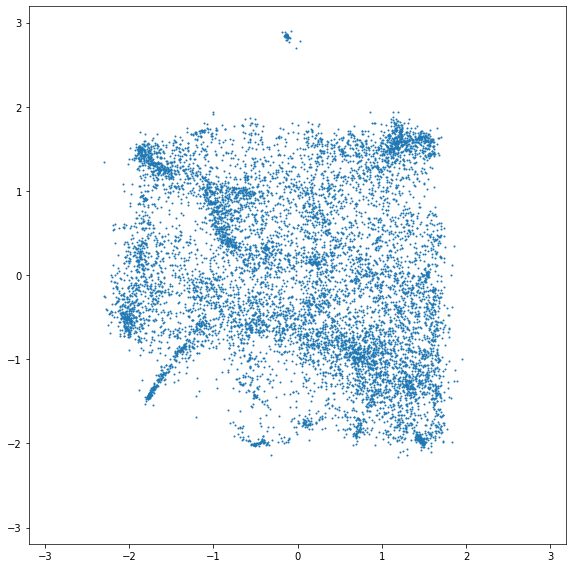

In [ ]:
pymde.plot(embedding)

In [ ]:
# mde.play(savepath='./graphs/circles1.gif')

In [ ]:
embedding.shape

torch.Size([9899, 2])

---
Now I want to plot images as markers, instead of little dots.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm

In [ ]:
def plot_images_from_tensors(coords, image_paths, dpi=300, savefile = 'default.jpg', zoom=0.01):
    fig, ax = plt.subplots()
    fig.dpi = dpi
    fig.set_size_inches(11,8.5)
    
    cc = coords.cpu()
    x_max, y_max = cc.argmax(0)
    x_min, y_min = cc.argmin(0)
    
    low = min(cc[x_min][0], cc[y_min][1])
    high = max(cc[x_max][0], cc[y_max][1])
    sq_lim = max(abs(low), abs(high))
    
    plt.xlim(-sq_lim, sq_lim)
    plt.ylim(-sq_lim, sq_lim)

    for i, coord in tqdm(enumerate(coords)):
        try:
            x, y = coord

            path = str(image_paths[i])
            image = plt.imread(path)

            im = OffsetImage(image, zoom=zoom)
            im.image.axes = ax
            ab = AnnotationBbox(im, (x,y), frameon=False, pad=0.0,)
            ax.add_artist(ab)
        except SyntaxError:
            pass
    print("Drawing images as markers...")
    plt.savefig(savefile)
    print(f'Saved image to {savefile}')


In [ ]:
plot_images_from_tensors(embedding, memes.names, dpi=600, savefile='react.jpg')

6489it [01:21, 95.42it/s] 

In [ ]:
embedding

tensor([[ 1.9862, -1.4578],
        [ 0.5755, -1.0216],
        [ 1.4072, -0.6001],
        ...,
        [-0.5250, -1.0328],
        [-0.5270, -1.0371],
        [-0.5264, -1.0379]], device='cuda:0')

In [ ]:
to_delete = []
for coord, img in zip(embedding, memes.names):
    x, y = coord
    if x < -2 or y < -1:
        to_delete.append(img)

In [ ]:
len(to_delete)

335

In [ ]:
from pathlib import Path

In [ ]:
for img in to_delete:
    imgpath = Path(img)
    imgpath.unlink()

It worked! A better distribution and fewer of the wrong things